In [1]:
import math

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.stats as stats
from datetime import datetime,date

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
us_covid_with_dates = pd.read_pickle('../datasets/us_covid_with_dates.pkl')

In [4]:
us_covid_with_dates.head()

,2020-01-21 00:00:00,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,...,2020-03-29 00:00:00,2020-03-30 00:00:00,2020-03-31 00:00:00,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-03 00:00:00,2020-04-04 00:00:00,2020-04-05 00:00:00,2020-04-06 00:00:00,Effective Date
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.277778,14.096386,5.491024,10.710711,14.828210,20.866142,6.384365,12.737293,8.962520,2020-04-04
Alaska,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.764706,4.385965,11.764706,7.518797,2.097902,6.849315,8.333333,9.467456,2.162162,2020-03-28
Arizona,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.181113,25.834230,11.035073,8.859784,13.234253,10.562500,14.132278,12.382368,8.638167,2020-03-31
California,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.596586,18.432812,15.644792,14.378933,13.997555,12.323503,9.762113,9.278052,8.012735,2020-03-19
Colorado,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.324115,13.520518,13.774734,11.906355,11.416617,12.178112,9.373505,8.220376,4.484848,2020-03-26


In [140]:
class State():
    
    def __init__(self, percent_increases, dates, name):
        '''
        percent_increases: floats with last entry being date in 
                                which the stay-at-home order was effective.
        dates: pandas._libs.tslibs.timestamps.Timestamp with last 
                    entry being 'Effective Date'
        '''
        self.percent_increases = self.parse_increases(percent_increases)
        self.dates = self.parse_dates(dates, percent_increases)
        self.name = name
        self.stay_home_date = self.stay_home(percent_increases)
        
    def parse_increases(self, perc_inc):
        '''Returns only the percent increases (takes away 0's and the 
        effective date)'''
        #strip perc_inc of stay-at-home order date
        perc_inc_ = perc_inc[:-1]
        
        #get only the data that is more than 0
        perc_greater = perc_inc_[perc_inc_ > 0]
        
        return perc_greater
    
    def parse_dates(self, date, perc_inc):
        '''Returns only the days that have percent increases'''
        #strip perc_inc of stay-at-home order date
        perc_inc_ = perc_inc[:-1]
        
        #get only the data that is more than 0
        perc_greater = perc_inc_[perc_inc_ > 0]
        
        #strip dates of last entry
        date_ = date[:-1]
        
        #get only the dates that the perc_inc is more than 0
        dates_greater = date_[perc_inc_ > 0]
        
        return dates_greater
    
    def stay_home(self, perc_inc):
        '''Returns the day at which the state implemented stay-at-home order'''
        return perc_inc[-1]
    
    def plot_percent_changes(self, ax):
        '''Generates a random color and plots the percent increase per day
        and plots a vertical line at the stay_home_date in the same color'''
        random_color = np.random.rand(3,)
        ax.plot(self.dates, self.percent_increases, c=random_color,
                label=self.name)
        
        ax.axvline(self.stay_home_date, linestyle="--", c=random_color,
                  label = '{} Stay-Home Date'.format(self.name))

        
    # Hypothesis Testing
    def get_pre_increase(self):
        '''Returns only the data before social distancing was implented plus
        7 days (hypothetically how many days to actually see the effects)'''
        
        #define the federal social distancing date
        federal_dist_date = '2020-03-16'
        federal_dist_date = pd.to_datetime(federal_dist_date)
        
        #get the index where the federal social distancing date is at
        index_social = list(self.dates).index(federal_dist_date)
        
        return self.percent_increases[:index_social + 7]
    
    def get_post_increase(self):
        '''Returns only the data after social distancing was implented plus
        8 days (hypothetically how many days to actually see the effects)'''
        
        #define the federal social distancing date
        federal_dist_date = '2020-03-16'
        federal_dist_date = pd.to_datetime(federal_dist_date)
        
        #get the index where the federal social distancing date is at
        index_social = list(self.dates).index(federal_dist_date)
        
        return self.percent_increases[index_social + 8:]
    
    def calc_p_value(self):
        stat, p_val = stats.ttest_ind(self.get_pre_increase(), 
                                      self.get_post_increase(), 
                                      equal_var = False)
        return p_val

In [141]:
def generate_labels(ax):
    '''generates labels and formats axes'''
    ax.legend(fontsize=14)
    fig.autofmt_xdate()
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 4));
    ax.set_ylabel('Percent Change Per Day')
    ax.yaxis.label.set_size(20)
    ax.set_xlabel('Date')
    ax.xaxis.label.set_size(20)
    ax.set_title('Percent Change and Stay-Home Dates')

In [142]:
def plot_social_distance(ax, date):
    '''Plots vertical line on axis that shows the date at which social distancing was implemented.
    Inputs
    ------
    ax: matplotlib ax to plot on
    dates: pandas._libs.tslibs.timestamps.Timestamp with last entry being 'Effective Date'
    label: string
    
    Returns
    -------
    None   
    
    '''
    ax.axvline(date, color="green", linestyle="--", 
               label='Federal Social Distancing Date')

In [143]:
def get_social_distance_date():
    federal_dist_date = '2020-03-16'
    federal_dist_date = pd.to_datetime(federal_dist_date)
    return federal_dist_date

## Make a list of State objects

In [99]:
all_states = []

for each_state in us_covid_with_dates.index:
    each_state = State(us_covid_with_dates.loc[each_state, :], 
                   us_covid_with_dates.columns, each_state)
    all_states.append(each_state)

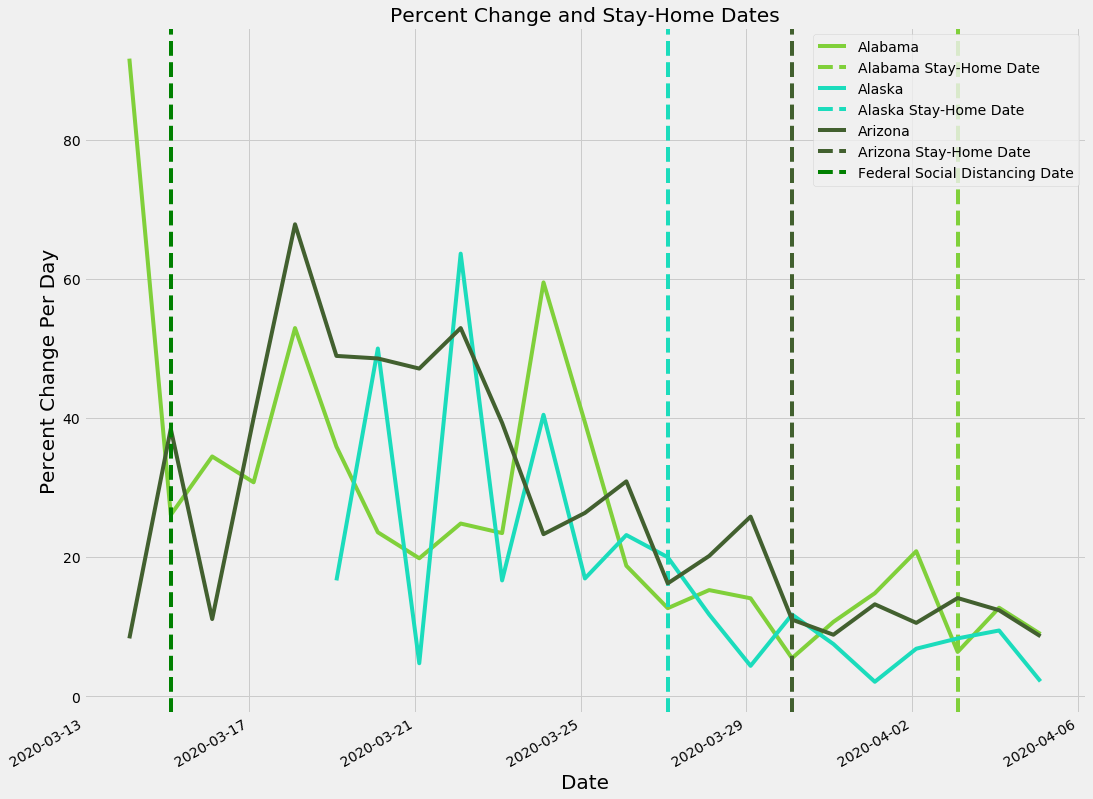

In [101]:
fig, ax = plt.subplots(figsize=(16,14))

for each_state in all_states[0:3]:
    each_state.plot_percent_changes(ax)
    
plot_social_distance(ax, get_social_distance_date())
generate_labels(ax)

In [103]:
for each_state in all_states[0:3]:
    print(each_state.name)

Alabama
Alaska
Arizona


In [144]:
washington = State(us_covid_with_dates.loc['Washington', :], 
                   us_covid_with_dates.columns, 'Washington')

In [147]:
washington.calc_p_value()

0.0001700621310824477